In [8]:
import json
import pandas as pd
from google.cloud import bigquery
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd

import re
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle



Skipping field opening: unsupported OGR type: 1
Skipping field opening: unsupported OGR type: 1


⚠️ PAs with no area match (check spelling in polygons or PA ids):
    hfb_no  pa_no              pa_name pa_code
41      10   1018  Children's lighting  PA1018
44      10   1043  Integrated lighting  PA1043
### rows with conversion > 1 ###
    hfb_no  pa_no                                 pa_name  visitors  \
9        2    216                  Wall shelves & storage      1495   
22       6    621                Bathroom around the sink      4654   
23       6    623   Bathroom, shower and toilet solutions     11494   
25       6    632           Shower mixers and accessories       302   
42      10   1021  Power supply, charging and accessories      1172   
43      10   1031                           Light sources      4645   
44      10   1043                     Integrated lighting       858   
45      10   1081                       Seasonal Lighting       400   
46      11   1111                 Sheets and pillow cases      3896   
50      11   1122                                 

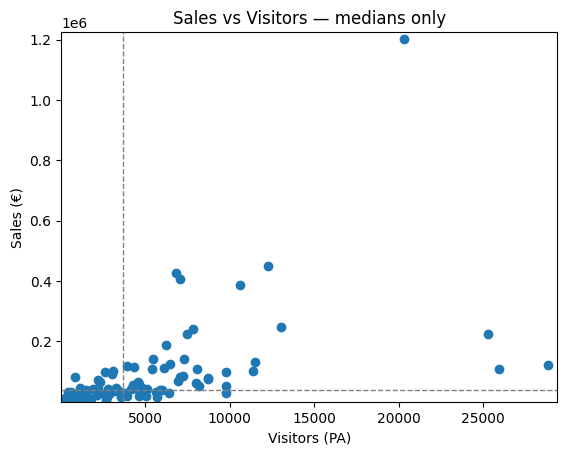

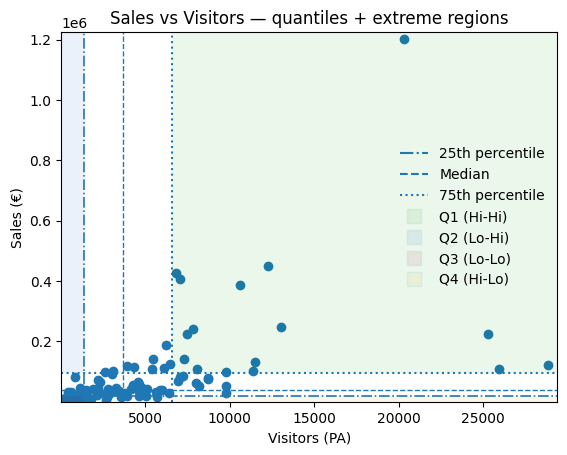

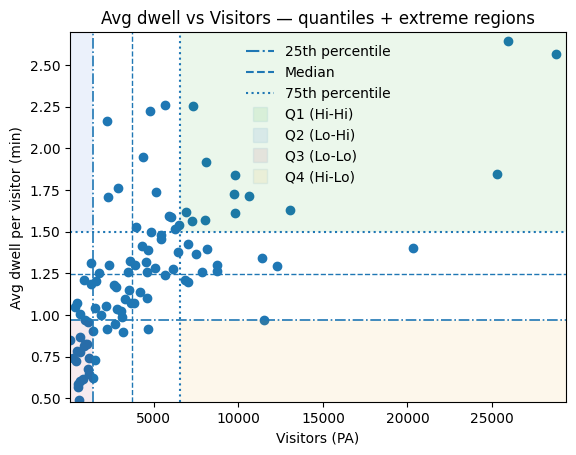

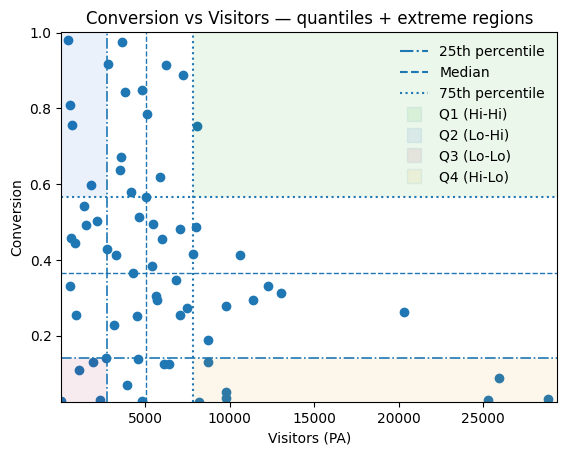

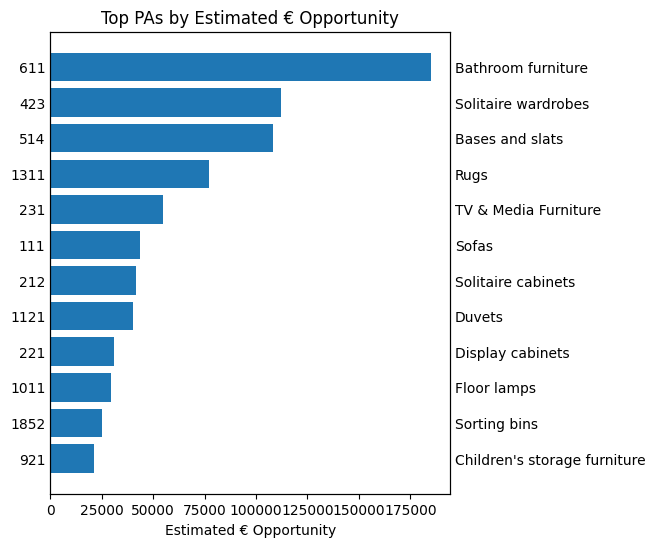

In [9]:


# -----------------------------
# 0) Load your data
# -----------------------------
DATA_PATH = "merged_pa_may_31Oct_NL.csv"   # or your local path
POLY_PATH_1 = "files_Geojson/final_floor1_october.geojson"
POLY_PATH_2 = "files_Geojson/final_floor2_october.geojson"

merged_df_pa = pd.read_csv(DATA_PATH)

# Column names (edit if yours differ)
DATE   = "date" if "date" in merged_df_pa.columns else "transaction_date"
PA_ID  = "pa_no"
PA_NM  = "pa_name" if "pa_name" in merged_df_pa.columns else ("name" if "name" in merged_df_pa.columns else None)
HFB    = "hfb_no"
VIS    = "visitors"
AVGMIN = "avg_time"
SALES  = "created_sales_net_amount_euro"
TXNS   = "unique_transaction_identifier" if "unique_transaction_identifier" in merged_df_pa.columns else None
ITEMS  = "created_net_quantity" if "created_net_quantity" in merged_df_pa.columns else None

# -----------------------------
# 1) Helpers
# -----------------------------
def extract_pa_code(x: object, width: int = 4):
    """
    Normalize anything like 'PA 1234 rail', 'PA-1011 A', 'pa1011', '1011' → 'PA1011'
    Returns NaN if no digits are found.
    """
    s = str(x).strip()
    # look for 'PA' then any non-digits, then the digits
    m = re.search(r'(?i)\bPA\D*(\d{1,6})', s)
    if not m:
        # fallback: bare number
        m = re.search(r'\b(\d{1,6})\b', s)
    if m:
        num = m.group(1).zfill(width)
        return f"PA{num}"
    return np.nan

def num(x):
    return pd.to_numeric(x, errors="coerce")

# -----------------------------
# 2) Clean & filter facts
# -----------------------------
df = merged_df_pa.copy()
df[DATE] = pd.to_datetime(df[DATE], errors="coerce")

# Filter by September 2025 (use DATE constant!)
df = df.loc[(df[DATE] >= "2025-10-01") & (df[DATE] <= "2025-10-31")].copy()

# Remove obvious bad rows: visitors == 0 but we have transactions > 0 (if TXNS exists)
if TXNS and TXNS in df.columns:
    df = df.loc[~((df[VIS] == 0) & (df[TXNS] > 0))].copy()

# Cast numerics safely
for c in [VIS, AVGMIN, SALES, TXNS, ITEMS]:
    if c and c in df.columns:
        df[c] = num(df[c])

# Per-row dwell minutes
df["total_dwell_min_row"] = df[VIS] * df[AVGMIN]

# -----------------------------
# 3) Aggregate to PA (keep HFB)
# -----------------------------
group_keys = [HFB, PA_ID] + ([PA_NM] if PA_NM else [])
summary = (df.groupby(group_keys, as_index=False)
             .agg(visitors=(VIS, "sum"),
                  transactions=(TXNS, "sum") if TXNS else (VIS, lambda s: np.nan),  # keep shape if TXNS missing
                  sales=(SALES, "sum"),
                  total_dwell_min=("total_dwell_min_row", "sum")))

# KPIs
summary["avg_dwell_per_visitor"] = summary["total_dwell_min"] / summary["visitors"].replace(0, np.nan)
summary["conversion"]            = summary["transactions"] / summary["visitors"].replace(0, np.nan)
summary["spdm"]                  = summary["sales"] / summary["total_dwell_min"].replace(0, np.nan)
summary["aov"]                   = summary["sales"] / summary["transactions"].replace(0, np.nan)

# -----------------------------
# 4) Bring in polygon areas
# -----------------------------
# Read polygons and ensure WGS84 (leaflet-friendly)
polys_1 = gpd.read_file(POLY_PATH_1)
if polys_1.crs is None:
    polys_1.set_crs("EPSG:4326", inplace=True)  # assume WGS84 if missing
else:
    polys_1 = polys_1.to_crs("EPSG:4326")
polys_1["floor"] = 1

polys_2 = gpd.read_file(POLY_PATH_2)
if polys_2.crs is None:
    polys_2.set_crs("EPSG:4326", inplace=True)
else:
    polys_2 = polys_2.to_crs("EPSG:4326")
polys_2["floor"] = 2

polys = pd.concat([polys_1, polys_2], ignore_index=True)

# pick the text field that holds the PA string (fall through options)
name_field = next((c for c in ["name", "pa_name", "label", "pa", "PA", "pa_no", "id"] if c in polys.columns), None)
if not name_field:
    raise KeyError("No suitable PA name field found in polygons. Expected one of: name, pa_name, label, pa, PA, pa_no, id")

# Normalize PA codes on BOTH sides
summary["pa_code"] = summary[PA_ID].apply(extract_pa_code)
polys["pa_code"]   = polys[name_field].apply(extract_pa_code)

# Compute area (use existing field if present; else approximate by projecting to meters)
if "geodesic_area" in polys.columns:
    polys["poly_area_m2"] = num(polys["geodesic_area"]).abs()
else:
    # approximate planar area in Web Mercator (ok at store scale)
    polys_m = polys.to_crs(3857)
    polys["poly_area_m2"] = polys_m.geometry.area

# Sum area across pieces for same PA
area_pa = (polys.groupby("pa_code", as_index=False)
                .agg(area_pa_m2=("poly_area_m2", "sum")))
summary = summary.merge(area_pa, on="pa_code", how="left")

# Also bring the (single) floor label per PA
summary = summary.merge(
    polys[["pa_code", "floor"]].drop_duplicates("pa_code"),
    on="pa_code",
    how="left",
    validate="m:1"
)

# Optional: quick QA to see what didn’t match (areas null)
unmatched = summary[summary["area_pa_m2"].isna()][[HFB, PA_ID, PA_NM, "pa_code"]]
if not unmatched.empty:
    print("⚠️ PAs with no area match (check spelling in polygons or PA ids):")
    print(unmatched.head(20))

# -----------------------------
# 5) Benchmarks & opportunity
# -----------------------------
model = summary[summary["conversion"] < 1].copy()
print("### rows with conversion > 1 ###")
print(summary[summary["conversion"] >= 1])

bench = (model.groupby(HFB, as_index=False)
           .agg(target_conv_hfb=("conversion", "median"),
                target_spdm_hfb=("spdm", lambda s: s.quantile(0.75))))

model = model.merge(bench, on=HFB, how="left")

# cap target conv to at most 2x current conv
model["target_conv_hfb_w_cap"] = np.minimum(model["target_conv_hfb"], 2.0 * model["conversion"])
model["gap_tx_hfb"]            = np.maximum(model["target_conv_hfb_w_cap"] - model["conversion"], 0) * model["visitors"]

model["euro_gap_conv"] = model["gap_tx_hfb"] * model["aov"]
model["euro_gap_spdm"] = np.maximum(model["target_spdm_hfb"] - model["spdm"], 0) * model["total_dwell_min"]

model["opp_score"] = model["euro_gap_conv"].fillna(0)

merge_cols = [HFB, PA_ID] + ([PA_NM] if PA_NM else [])
summary = summary.merge(
    model[merge_cols + ["target_conv_hfb","target_conv_hfb_w_cap","target_spdm_hfb",
                        "gap_tx_hfb","euro_gap_conv","euro_gap_spdm","opp_score"]],
    on=merge_cols,
    how="left"
)

# -----------------------------
# 6) (Your plotting code unchanged)
# -----------------------------
def get_quants(x):
    return (np.nanpercentile(x, 25), np.nanpercentile(x, 50), np.nanpercentile(x, 75))

def set_margins(ax, x, y):
    xmin, xmax = np.nanmin(x), np.nanmax(x)
    ymin, ymax = np.nanmin(y), np.nanmax(y)
    if xmin == xmax:
        delta = 0.05 * (abs(xmin) + 1)
        xmin -= delta; xmax += delta
    if ymin == ymax:
        delta = 0.05 * (abs(ymin) + 1)
        ymin -= delta; ymax += delta
    ax.set_xlim(xmin*0.98, xmax*1.02)
    ax.set_ylim(ymin*0.98, ymax*1.02)

def add_median_lines(ax, x, y, xlab, ylab):
    medx = np.nanmedian(x); medy = np.nanmedian(y)
    ax.axvline(medx, linestyle="--", linewidth=1.0, color="gray")
    ax.axhline(medy, linestyle="--", linewidth=1.0, color="gray")
    ax.set_xlabel(xlab); ax.set_ylabel(ylab)

def add_quantile_refs_and_shading(ax, x, y, xlab, ylab):
    q1x, medx, q3x = get_quants(x)
    q1y, medy, q3y = get_quants(y)
    ax.axvline(q1x, linestyle="-.", linewidth=1.2)
    ax.axvline(medx, linestyle="--", linewidth=1.0)
    ax.axvline(q3x, linestyle=":",  linewidth=1.5)
    ax.axhline(q1y, linestyle="-.", linewidth=1.2)
    ax.axhline(medy, linestyle="--", linewidth=1.0)
    ax.axhline(q3y, linestyle=":",  linewidth=1.5)
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    patches = [
        ("Q1 (Hi-Hi)", q3x, q3y, xmax-q3x,  ymax-q3y,  (0.0, 0.6, 0.0, 0.08)),
        ("Q2 (Lo-Hi)", xmin, q3y, q1x-xmin, ymax-q3y,  (0.0, 0.3, 0.8, 0.08)),
        ("Q3 (Lo-Lo)", xmin, ymin, q1x-xmin, q1y-ymin, (0.6, 0.0, 0.2, 0.08)),
        ("Q4 (Hi-Lo)", q3x, ymin, xmax-q3x, q1y-ymin,  (0.9, 0.6, 0.0, 0.08)),
    ]
    legend_patches = []
    for label, x0, y0, w, h, color in patches:
        if w > 0 and h > 0:
            rect = Rectangle((x0, y0), w, h, facecolor=color, edgecolor="none")
            ax.add_patch(rect)
            legend_patches.append(Line2D([0],[0], marker="s", linestyle="None",
                                         markersize=10, markerfacecolor=color, label=label))
    ax.set_xlabel(xlab); ax.set_ylabel(ylab)
    line_handles = [
        Line2D([0],[0], linestyle="-.", label="25th percentile"),
        Line2D([0],[0], linestyle="--", label="Median"),
        Line2D([0],[0], linestyle=":",  label="75th percentile"),
    ]
    ax.legend(handles=line_handles + legend_patches, loc="best", frameon=False)

# Examples (same as yours)
plt.figure(); ax = plt.gca()
ax.scatter(summary["visitors"], summary["sales"]); set_margins(ax, summary["visitors"], summary["sales"])
add_median_lines(ax, summary["visitors"], summary["sales"], "Visitors (PA)", "Sales (€)")
plt.title("Sales vs Visitors — medians only"); plt.show()

plt.figure(); ax = plt.gca()
ax.scatter(summary["visitors"], summary["sales"]); set_margins(ax, summary["visitors"], summary["sales"])
add_quantile_refs_and_shading(ax, summary["visitors"], summary["sales"], "Visitors (PA)", "Sales (€)")
plt.title("Sales vs Visitors — quantiles + extreme regions"); plt.show()

plt.figure(); ax = plt.gca()
ax.scatter(summary["visitors"], summary["avg_dwell_per_visitor"])
set_margins(ax, summary["visitors"], summary["avg_dwell_per_visitor"])
add_quantile_refs_and_shading(ax, summary["visitors"], summary["avg_dwell_per_visitor"], "Visitors (PA)", "Avg dwell per visitor (min)")
plt.title("Avg dwell vs Visitors — quantiles + extreme regions"); plt.show()

plt.figure(); ax = plt.gca()
mask = summary["conversion"] < 1
ax.scatter(summary.loc[mask,"visitors"], summary.loc[mask,"conversion"])
set_margins(ax, summary.loc[mask,"visitors"], summary.loc[mask,"conversion"])
add_quantile_refs_and_shading(ax, summary.loc[mask,"visitors"], summary.loc[mask,"conversion"], "Visitors (PA)", "Conversion")
plt.title("Conversion vs Visitors — quantiles + extreme regions"); plt.show()

TOP_N = 12
top_pool = summary[summary["opp_score"].notna()]
top = top_pool.nlargest(TOP_N, "opp_score").copy()
y_pos = np.arange(len(top))
fig, ax = plt.subplots(figsize=(8, 6)); fig.subplots_adjust(left=0.25, right=0.75)
ax.barh(y_pos, top["opp_score"])
ax.set_xlabel("Estimated € Opportunity"); ax.set_title("Top PAs by Estimated € Opportunity")
ax.set_yticks(y_pos); ax.set_yticklabels(top[PA_ID].astype(str)); ax.tick_params(axis='y', length=0); ax.invert_yaxis()
if PA_NM and (PA_NM in top.columns):
    ax2 = ax.twinx(); ax2.set_ylim(ax.get_ylim()); ax2.set_yticks(y_pos); ax2.set_yticklabels(top[PA_NM]); ax2.tick_params(axis='y', length=0)
plt.show()


### Analyse quickly the top and rank it ###

In [10]:
summary.loc[summary.conversion >1][['hfb_no','pa_no','pa_name','visitors','transactions','conversion']].sort_values(["conversion"], ascending=False)


,hfb_no,pa_no,pa_name,visitors,transactions,conversion
95,18,1836,Bags and travel accessories,499,6412,12.849699
70,14,1433,Washing up,929,5988,6.445640
67,14,1423,Knives,617,3715,6.021070
72,15,1512,Serving,231,1358,5.878788
74,15,1531,Cutlery,597,2172,3.638191
42,10,1021,"Power supply, charging and accessories",1172,4059,3.463311
66,14,1421,Cooking utensils,1296,3770,2.908951
77,15,1551,Mugs and cups,1129,3279,2.904340
45,10,1081,Seasonal Lighting,400,1078,2.695000
69,14,1431,Food containers,7288,19287,2.646405


In [11]:
summary

,hfb_no,pa_no,pa_name,visitors,transactions,sales,total_dwell_min,avg_dwell_per_visitor,conversion,spdm,...,pa_code,area_pa_m2,floor,target_conv_hfb,target_conv_hfb_w_cap,target_spdm_hfb,gap_tx_hfb,euro_gap_conv,euro_gap_spdm,opp_score
0,1,111,Sofas,25282,764,224616.912044,46626.16,1.844243,0.030219,4.817401,...,PA0111,539.3310,2.0,0.036097,0.036097,6.686781,148.595901,43687.372251,87162.018036,43687.372251
1,1,113,Sofa beds,8167,211,52805.449256,11394.34,1.395168,0.025836,4.634358,...,PA0113,119.1371,2.0,0.036097,0.036097,6.686781,83.801468,20972.389497,23386.009234,20972.389497
2,1,121,Sofa tables,11389,3358,102122.127302,15272.24,1.340964,0.294846,6.686781,...,PA0121,129.5672,2.0,0.036097,0.036097,6.686781,0.000000,0.000000,0.000000,0.000000
3,1,125,Armchairs,9807,354,51970.068586,15776.25,1.608672,0.036097,3.294197,...,PA0125,127.2400,2.0,0.036097,0.036097,6.686781,0.000000,0.000000,53522.263308,0.000000
4,1,126,Footstools,928,237,14921.651240,764.29,0.823588,0.255388,19.523546,...,PA0126,9.7562,2.0,0.036097,0.036097,6.686781,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,18,1836,Bags and travel accessories,499,6412,6726.564823,292.09,0.585351,12.849699,23.029083,...,PA1836,12.1942,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,18,1852,Sorting bins,5997,2730,38208.527157,9514.50,1.586543,0.455228,4.015821,...,PA1852,149.4801,1.0,0.755760,0.755760,7.087618,1802.294931,25224.554876,29226.617144,25224.554876
97,18,1881,"Kits, tools and chemical products",651,492,2436.909185,393.09,0.603825,0.755760,6.199367,...,PA1881,23.2095,1.0,0.755760,0.755760,7.087618,0.000000,0.000000,349.162692,0.000000
98,70,7011,Ovens,4827,130,45841.510000,7214.59,1.494632,0.026932,6.354001,...,PA7011,75.0939,2.0,0.028423,0.028423,8.460158,7.198718,2538.462314,15195.061260,2538.462314


In [12]:
sub_set_rank = summary.loc[summary.conversion <1][['hfb_no', 'pa_no', 'pa_name', 'visitors', 
                                                   'transactions', 'sales','total_dwell_min',
                                                   'avg_dwell_per_visitor', 'conversion', 'spdm', 'aov',
                                                   'pa_code', 'area_pa_m2', 'floor']]

sub_set_rank['traffic_per_m2'] = sub_set_rank['visitors'] /sub_set_rank['area_pa_m2']
sub_set_rank['sales_per_m2'] = sub_set_rank['sales'] /sub_set_rank['area_pa_m2']

sub_set_rank.head()
#summary.sort_values(by="density_traffic",ascending=[False])


,hfb_no,pa_no,pa_name,visitors,transactions,sales,total_dwell_min,avg_dwell_per_visitor,conversion,spdm,aov,pa_code,area_pa_m2,floor,traffic_per_m2,sales_per_m2
0,1,111,Sofas,25282,764,224616.912044,46626.16,1.844243,0.030219,4.817401,294.001194,PA0111,539.3310,2.0,46.876593,416.473209
1,1,113,Sofa beds,8167,211,52805.449256,11394.34,1.395168,0.025836,4.634358,250.262793,PA0113,119.1371,2.0,68.551274,443.232622
2,1,121,Sofa tables,11389,3358,102122.127302,15272.24,1.340964,0.294846,6.686781,30.411592,PA0121,129.5672,2.0,87.900333,788.178855
3,1,125,Armchairs,9807,354,51970.068586,15776.25,1.608672,0.036097,3.294197,146.808103,PA0125,127.2400,2.0,77.074819,408.441281
4,1,126,Footstools,928,237,14921.651240,764.29,0.823588,0.255388,19.523546,62.960554,PA0126,9.7562,2.0,95.119001,1529.453193


In [13]:
### reviewed to take into account the area
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def slope_two_way(df, top_n=5,
                  metric_from="visitors",
                  metric_to=None,          # e.g. "traffic_per_m2" or "sales_per_m2"
                  floors=None,             # 1, [1,2], or None
                  label_col="pa_name",
                  x_gap=2.0,               # was 3; smaller = less space between from/to
                  text_pad=0.25):          # was ~0.35; tighter label padding
    d = df.copy()

    # Filter floors (optional)
    if floors is not None and "floor" in d.columns:
        fl = floors if isinstance(floors, (list, tuple, set)) else [floors]
        d = d[d["floor"].isin(fl)]

    # Pick metric_to if not given (very simple rule)
    if metric_to is None:
        if "traffic_per_m2" in d.columns:
            metric_to = "traffic_per_m2"
        elif {"visitors","area_pa_m2"}.issubset(d.columns):
            d["visitors_per_m2"] = d["visitors"] / d["area_pa_m2"].replace(0, np.nan)
            metric_to = "visitors_per_m2"
        else:
            raise ValueError("Provide metric_to or include traffic_per_m2 or visitors & area_pa_m2.")

    d = d.dropna(subset=[metric_from, metric_to]).copy()

    key = "pa_code" if "pa_code" in d.columns else ("pa_no" if "pa_no" in d.columns else label_col)
    N = d[key].nunique()

    # Ranks (1 = best)
    d["rank_from"] = d[metric_from].rank(ascending=False, method="min").astype(int)
    d["rank_to"]   = d[metric_to].rank(ascending=False, method="min").astype(int)

    # Top-N sets
    left_top  = d.nsmallest(top_n, "rank_from")
    right_top = d.nsmallest(top_n, "rank_to")

    left_ids  = set(left_top[key])

    # Union: left Top-N + right Top-N not already on the left
    sel = pd.concat([left_top, right_top[~right_top[key].isin(left_ids)]], ignore_index=True)
    sel = sel[[key, label_col, "rank_from", "rank_to"]].copy()
    sel["from_topN"] = sel[key].isin(left_ids)   # True = came from left Top-N

    # ---- label formatter ----
    def _format_label(val, wrap_after_words=4):
        s = "" if pd.isna(val) else str(val).strip()
        # special-case long kitchen label
        if s.lower() == "kitchen fronts, coverpanels, plinths and deco strips":
            return "kitchen fronts"
        # wrap after N words (two lines)
        words = s.split()
        if len(words) > wrap_after_words:
            s = " ".join(words[:wrap_after_words]) + "\n" + " ".join(words[wrap_after_words:])
        return s

    # -------- PLOT --------
    fig, ax = plt.subplots(figsize=(11, 6))
    x0, x1 = 0.0, float(x_gap)  # tighter spacing than the original (0, 3)

    # Draw lines (solid = left Top-N; dashed = right-only Top-N)
    for _, r in sel.sort_values(["from_topN","rank_from"], ascending=[False, True]).iterrows():
        name = _format_label(r[label_col]); y0, y1 = r["rank_from"], r["rank_to"]
        ls  = "-" if r["from_topN"] else "--"
        col = "C0" if r["from_topN"] else "C3"   # blue (left topN) / red (right-only)
        ax.plot([x0, x1], [y0, y1], marker="o", linestyle=ls, color=col, alpha=0.9)
        ax.text(x0 - text_pad, y0, f"{name}  #{y0}", ha="right", va="center", color=col)
        ax.text(x1 + text_pad, y1, f"#{y1}  {name}", ha="left",  va="center", color=col)

    # Axis formatting: no legend, no border, no ticks
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xticks([x0, x1]); ax.set_xticklabels([metric_from, metric_to])
    ax.tick_params(axis="x", length=0)  # keep x labels, hide tick marks
    ax.set_yticks([])                   # remove y ticks & labels
    ax.grid(False)
    ax.invert_yaxis()
    ax.set_xlim(x0 - 0.6, x1 + 0.6)     # keep similar outer margins

    # Title
    floor_txt = ""
    if "floor" in d.columns:
        if floors is None:
            fl = sorted(d["floor"].dropna().unique().tolist())
            if len(fl)==1: floor_txt = f" — Floor {int(fl[0])}"
            elif len(fl)>1: floor_txt = " — Floors " + " & ".join(str(int(f)) for f in fl)
        else:
            fl = floors if isinstance(floors, (list, tuple, set)) else [floors]
            floor_txt = " — Floors " + " & ".join(str(int(f)) for f in sorted(fl))

    title_main = f"Top {top_n} by {metric_from} & by {metric_to}{floor_txt}"
    title_sub  = f"from #1 Rank = best (out of {N})"
    ax.set_title(f"{title_main}\n{title_sub}")

    plt.tight_layout()
    plt.show()

    # Return compact table
    return (sel.rename(columns={key: "pa_id"})
              .sort_values(["from_topN","rank_from"], ascending=[False, True])
              .reset_index(drop=True))


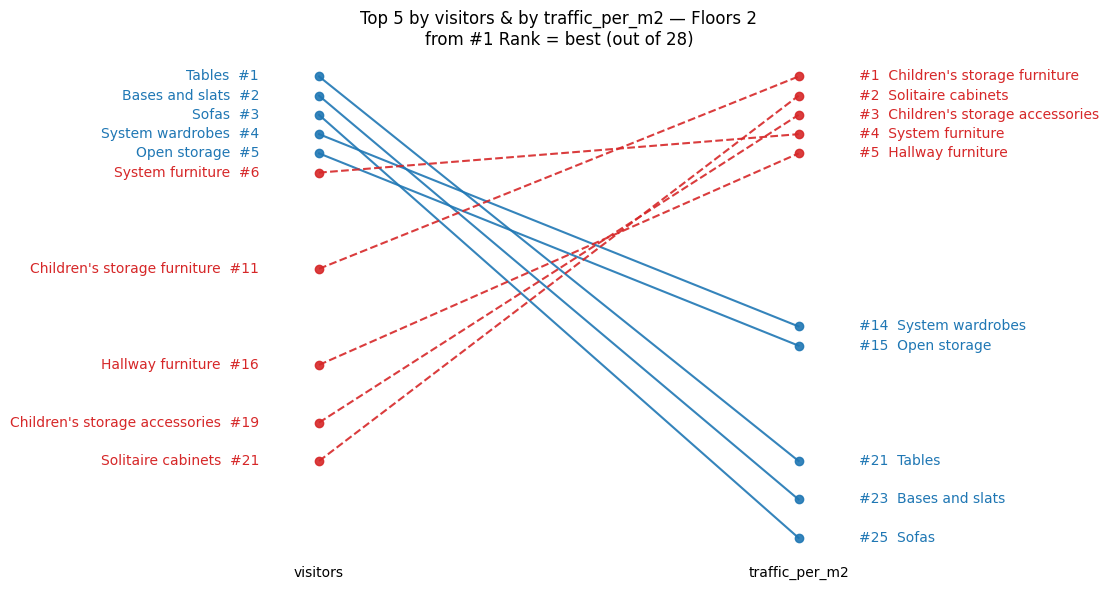

,pa_id,pa_name,rank_from,rank_to,from_topN
0,PA0811,Tables,1,21,True
1,PA0514,Bases and slats,2,23,True
2,PA0111,Sofas,3,25,True
3,PA0421,System wardrobes,4,14,True
4,PA0215,Open storage,5,15,True
5,PA0211,System furniture,6,4,False
6,PA0921,Children's storage furniture,11,1,False
7,PA0435,Hallway furniture,16,5,False
8,PA0922,Children's storage accessories,19,3,False
9,PA0212,Solitaire cabinets,21,2,False


In [14]:

slope_two_way(sub_set_rank, top_n=5,
                  metric_from="visitors",
                  metric_to="traffic_per_m2",          # e.g. "traffic_per_m2" or "sales_per_m2"
                  floors=2,             # 1, [1,2], or None
                  label_col="pa_name")


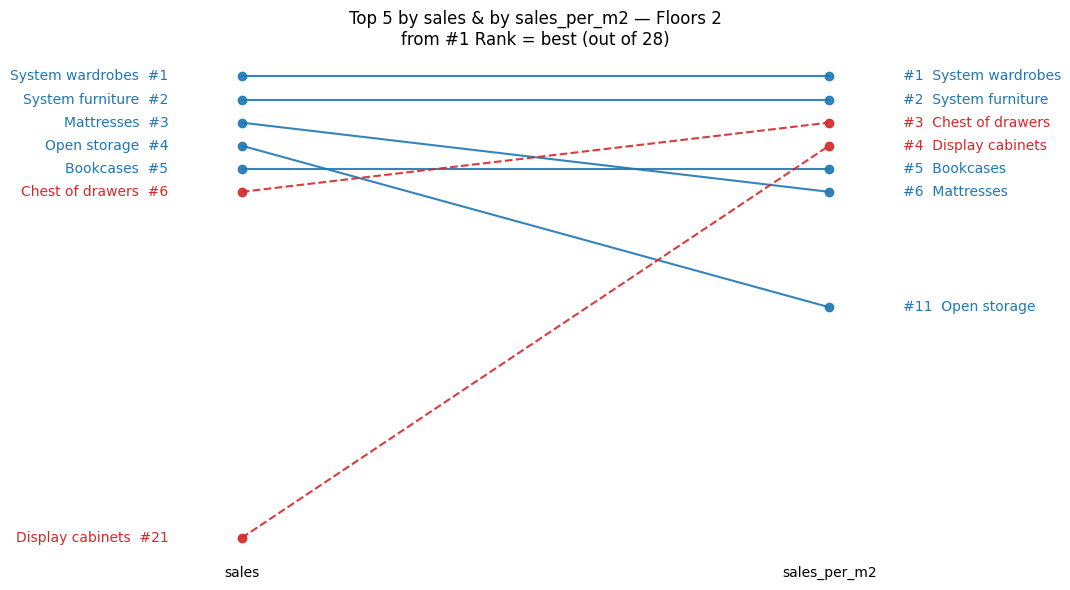

,pa_id,pa_name,rank_from,rank_to,from_topN
0,PA0421,System wardrobes,1,1,True
1,PA0211,System furniture,2,2,True
2,PA0511,Mattresses,3,6,True
3,PA0215,Open storage,4,11,True
4,PA0214,Bookcases,5,5,True
5,PA0431,Chest of drawers,6,3,False
6,PA0221,Display cabinets,21,4,False


In [15]:
slope_two_way(sub_set_rank, top_n=5,
                    metric_from='sales',
                    metric_to='sales_per_m2',           # e.g., 'traffic_per_m2' or 'sales_per_m2'
                    floors = 2,
                    label_col='pa_name')


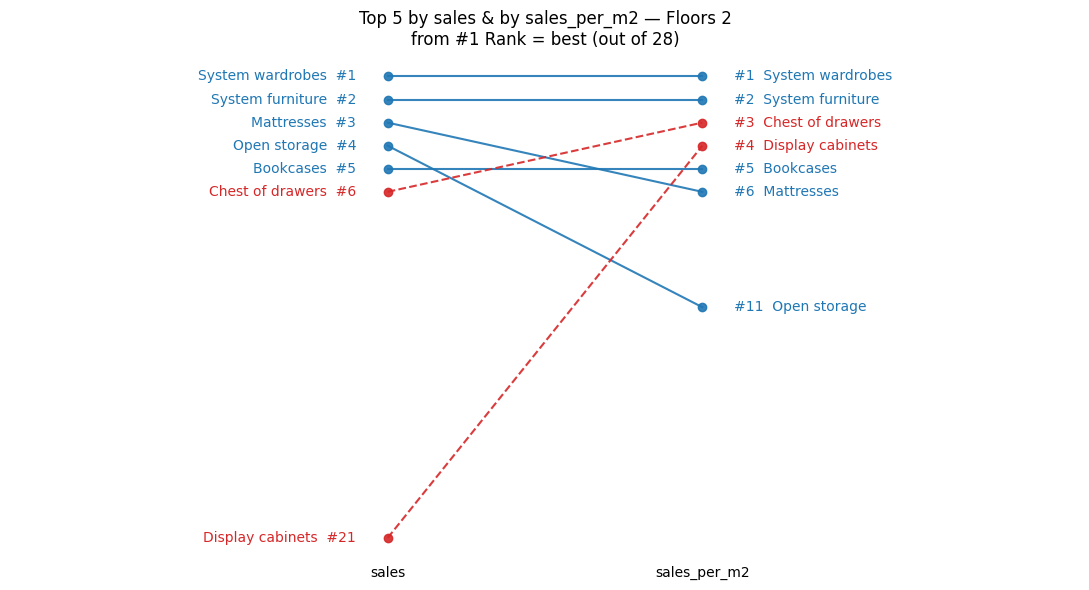

,pa_id,pa_name,rank_from,rank_to,from_topN
0,PA0421,System wardrobes,1,1,True
1,PA0211,System furniture,2,2,True
2,PA0511,Mattresses,3,6,True
3,PA0215,Open storage,4,11,True
4,PA0214,Bookcases,5,5,True
5,PA0431,Chest of drawers,6,3,False
6,PA0221,Display cabinets,21,4,False


In [16]:


slope_two_way(sub_set_rank, top_n=5,
                  metric_from="sales",
                  metric_to="sales_per_m2",          # e.g. "traffic_per_m2" or "sales_per_m2"
                  floors=2,             # 1, [1,2], or None
                  label_col="pa_name",
                  x_gap=0.5,               # was 3; smaller = less space between from/to
                  text_pad=0.05)

## Heatmap

In [17]:
# ============================================
# Folium PA heatmaps for one floor (robust PA parsing)
# ============================================

import re
import pandas as pd
import numpy as np
import geopandas as gpd
import folium
import branca

# ---------------------------
# 0) Inputs and column names
# ---------------------------
# If your DataFrame is not already in memory, read it from CSV:
# merged_df_pa = pd.read_csv("./input/merged_df_pa.csv")

POLY_PATH = "./files_Geojson/final_floor2_october.geojson"   # Floor polygons GeoJSON (one floor)

# Adjust these if your column names differ
DATE   = "date" if "date" in merged_df_pa.columns else "transaction_date"
PA_ID  = "pa_no"
PA_NM  = "pa_name" if "pa_name" in merged_df_pa.columns else ("name" if "name" in merged_df_pa.columns else None)
HFB    = "hfb_no"
VIS    = "visitors"
SALES  = "created_sales_net_amount_euro"
TXNS   = "unique_transaction_identifier" if "unique_transaction_identifier" in merged_df_pa.columns else None
ITEMS  = "created_net_quantity" if "created_net_quantity" in merged_df_pa.columns else None

# ---------------------------
# Helpers (PA parsing + numeric)
# ---------------------------
def extract_pa_code_first(x: object, width: int = 4) :
    """
    Normalize single PA code in facts:
    'PA 1234 rail' / 'PA-1011 A' / 'pa1011' / '1011' -> 'PA1234'
    Returns NaN if no digits found.
    """
    s = str(x).strip()
    m = re.search(r'(?i)\bPA\D*(\d{1,6})', s)
    if not m:
        m = re.search(r'\b(\d{1,6})\b', s)
    return f"PA{m.group(1).zfill(width)}" if m else np.nan

def extract_pa_codes_multi(x: object, width: int = 4) -> list[str]:
    """
    Parse ALL PA numbers from polygon labels:
    'PA 1081 en 1082' -> ['PA1081','PA1082']
    'PA 1011 A'       -> ['PA1011']
    'PA1081/1082'     -> ['PA1081','PA1082']
    """
    s = str(x).strip()
    m = re.search(r'(?i)\bPA\b(.*)', s)
    tail = m.group(1) if m else s
    nums = re.findall(r'(\d{1,6})', tail)
    if not nums:
        nums = re.findall(r'\b(\d{1,6})\b', s)
    # de-dup preserving order
    out, seen = [], set()
    for n in nums:
        code = f"PA{n.zfill(width)}"
        if code not in seen:
            seen.add(code); out.append(code)
    return out

def num(x):
    return pd.to_numeric(x, errors="coerce")

# ---------------------------
# 1) Clean & build daily KPIs
# ---------------------------
df = merged_df_pa.copy()
df[DATE] = pd.to_datetime(df[DATE], errors="coerce")

# Filter date range (use DATE constant!)
df = df.loc[(df[DATE] >= "2025-10-01") & (df[DATE] <= "2025-10-31")].copy()

# Remove days with visitors==0 but TX>0 (if TXNS available)
if TXNS and TXNS in df.columns:
    df = df.loc[~((df[VIS] == 0) & (df[TXNS] > 0))].copy()

# Cast numerics safely
for c in [VIS, SALES, TXNS, ITEMS]:
    if c and c in df.columns:
        df[c] = num(df[c])

# Daily totals per PA
gb_keys = [DATE, HFB, PA_ID] + ([PA_NM] if PA_NM else [])
agg_dict = {"visitors_day": (VIS, "sum"), "sales_day": (SALES, "sum")}
if TXNS and TXNS in df.columns:
    agg_dict["transactions_day"] = (TXNS, "sum")

daily = df.groupby(gb_keys, as_index=False).agg(**agg_dict)

# ------------------------------------------
# 2) Average across the dataset date range
# ------------------------------------------
agg2 = {
    "avg_daily_traffic": ("visitors_day", "mean"),
    "sum_traffic":       ("visitors_day", "sum"),
    "avg_daily_sales":   ("sales_day", "mean"),
    "n_days":            (DATE, "nunique"),
}
if "transactions_day" in daily.columns:
    agg2["sum_transactions"] = ("transactions_day", "sum")

avg_pa = daily.groupby([HFB, PA_ID] + ([PA_NM] if PA_NM else []), as_index=False).agg(**agg2)

# Robust conversion across the whole period
if "sum_transactions" in avg_pa.columns:
    avg_pa["avg_conversion"] = avg_pa["sum_transactions"] / avg_pa["sum_traffic"].replace(0, np.nan)
else:
    avg_pa["avg_conversion"] = np.nan

# ---------------------------
# 3) Load polygons & compute PA area (m²)
#    - Handle multi-PA labels and split area equally
# ---------------------------
polys = gpd.read_file(POLY_PATH)
polys = polys.to_crs(4326) if polys.crs else polys.set_crs(4326)

# Choose the field that stores the PA text
name_field = next((c for c in ["name", "pa_name", "label", "pa", "PA", "pa_no", "id"] if c in polys.columns), None)
if not name_field:
    raise KeyError("No suitable PA name field found in polygons (looked for: name, pa_name, label, pa, PA, pa_no, id).")

# Compute area (m²): prefer existing geodesic area, else project to meters
if "geodesic_area" in polys.columns:
    polys["poly_area_m2"] = num(polys["geodesic_area"]).abs()
else:
    polys_m = polys.to_crs(3857)  # Web Mercator: fine at store scale
    polys["poly_area_m2"] = polys_m.geometry.area

# Parse ALL PA codes from each polygon label and explode
polys["pa_codes"] = polys[name_field].apply(extract_pa_codes_multi)
polys["n_codes"]  = polys["pa_codes"].apply(len)
polys = polys.loc[polys["n_codes"] > 0].copy()
polys = polys.explode("pa_codes", ignore_index=True).rename(columns={"pa_codes": "pa_code"})
polys["area_share_m2"] = polys["poly_area_m2"] / polys["n_codes"]

# Aggregate area by PA code (area is split equally if a polygon contains multiple PAs)
area_pa = polys.groupby("pa_code", as_index=False).agg(area_pa_m2=("area_share_m2", "sum"))

# Attach normalized PA code to metrics and merge area
avg_pa["pa_code"] = avg_pa[PA_ID].apply(extract_pa_code_first)
avg_pa = avg_pa.merge(area_pa, on="pa_code", how="left")

# Traffic density & sales per m²
avg_pa["traffic_density"] = avg_pa["avg_daily_traffic"] / avg_pa["area_pa_m2"].replace(0, np.nan)
avg_pa["sales_per_m2"]    = avg_pa["avg_daily_sales"] / avg_pa["area_pa_m2"].replace(0, np.nan)

# ---------------------------
# 4) Broadcast metrics back to polygons
# ---------------------------
gdf = polys.merge(
    avg_pa[["pa_code", HFB, PA_ID] + ([PA_NM] if PA_NM else []) +
           ["avg_daily_traffic", "traffic_density", "avg_conversion",
            "avg_daily_sales", "sales_per_m2", "n_days"]],
    on="pa_code", how="left"
)

# Which column to show as name in tooltip
name_field_out = PA_NM if (PA_NM and PA_NM in gdf.columns) else "pa_code"

# ---------------------------
# 5) Simple function to draw one heatmap
# ---------------------------
def make_map(gdf_map, metric_col, title, fmt="{:,.2f}"):
    # Center map on the floor
    ctr = gdf_map.geometry.centroid
    m = folium.Map(location=[float(ctr.y.mean()), float(ctr.x.mean())],
                   zoom_start=18, tiles="cartodbpositron", control_scale=True)

    # Color scale (robust to outliers: 5th–95th percentiles)
    vals = gdf_map[metric_col].dropna()
    if len(vals) > 1:
        vmin, vmax = float(vals.quantile(0.05)), float(vals.quantile(0.95))
        if vmin == vmax:
            vmin, vmax = float(vals.min()), float(vals.max())
    else:
        vmin, vmax = 0.0, 1.0

    cmap = branca.colormap.LinearColormap(
        colors=["#2c7bb6", "#abd9e9", "#ffffbf", "#fdae61", "#d7191c"],
        vmin=vmin, vmax=vmax
    ).to_step(n=7)
    cmap.caption = title

    # Style: fill only polygons with data; others transparent with light outline
    def style_fn(feat):
        val = feat["properties"].get(metric_col, None)
        if val is None or pd.isna(val):
            return {"fillOpacity": 0.0, "weight": 0.6, "color": "#bfbfbf"}
        return {"fillColor": cmap(float(val)), "fillOpacity": 0.75, "weight": 0.6, "color": "#333333"}

    # Pre-format a copy for tooltip
    g = gdf_map.copy()
    g["_metric_val_fmt"] = g[metric_col].apply(lambda x: "" if pd.isna(x) else fmt.format(x))

    fields = [name_field_out, HFB if HFB in g.columns else None, "_metric_val_fmt", "n_days"]
    fields = [f for f in fields if f is not None]
    aliases = ["Area", "HFB", "Value", "Days"][:len(fields)]

    folium.GeoJson(
        data=g.to_json(),
        name=title,
        style_function=style_fn,
        tooltip=folium.GeoJsonTooltip(fields=fields, aliases=aliases, sticky=True, localize=True),
        highlight_function=lambda f: {"weight": 1.5, "color": "#000"},
    ).add_to(m)

    cmap.add_to(m)
    return m

# ---------------------------
# 6) Build the maps
# ---------------------------
m_avg_traffic  = make_map(gdf, "avg_daily_traffic", "Average Daily Traffic (visitors/day)", fmt="{:,.0f}")
m_density      = make_map(gdf, "traffic_density",   "Traffic Density (avg visitors/day per m²)", fmt="{:,.3f}")

gdf["_conv_pct"] = gdf["avg_conversion"] * 100.0
m_conversion   = make_map(gdf, "_conv_pct",         "Average Conversion (%)", fmt="{:.2f}%")

m_sales        = make_map(gdf, "avg_daily_sales",   "Average Daily Sales (€)", fmt="{:,.0f}")
m_sales_per_m2 = make_map(gdf, "sales_per_m2",      "Average Sales per m² (€)", fmt="{:,.0f}")

# ---- In Jupyter, display any:
# m_avg_traffic
# m_density
# m_conversion
# m_sales
# m_sales_per_m2


Skipping field opening: unsupported OGR type: 1
/var/folders/69/q_vmc6ns6_v503hjpfz65h8r0000gp/T/ipykernel_20252/3971212296.py:170: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ctr = gdf_map.geometry.centroid
/var/folders/69/q_vmc6ns6_v503hjpfz65h8r0000gp/T/ipykernel_20252/3971212296.py:170: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ctr = gdf_map.geometry.centroid
/var/folders/69/q_vmc6ns6_v503hjpfz65h8r0000gp/T/ipykernel_20252/3971212296.py:170: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ctr = gdf_map.geometry.centroid
/var/folders/69/q_vmc6ns6_v503hjpfz65h8r000

In [18]:
m_sales

In [19]:
m_avg_traffic


In [30]:
m_conversion

In [20]:
merged_df_pa.loc[merged_df_pa.pa_no==421].head()


,date,name,visitors,store,pa_no,hfb_no,pa_name,transaction_date,market_area_no,created_net_quantity,created_sales_net_amount_euro,unique_transaction_identifier,avg_time,visitors_hfb_daily,visitors_daily
27,2025-05-01,PA0421,615,445,421,4,System wardrobes,2025-05-01,445,208.0,11472.076784,45,1.65,2891,5381
225,2025-05-02,PA0421,762,445,421,4,System wardrobes,2025-05-02,445,215.0,11610.584989,57,1.07,4274,8022
359,2025-05-03,PA0421,1010,445,421,4,System wardrobes,2025-05-03,445,264.0,12550.503706,56,1.13,5584,9775
547,2025-05-04,PA0421,807,445,421,4,System wardrobes,2025-05-04,445,326.0,14008.917910,82,1.25,5361,10037
580,2025-05-05,PA0421,207,445,421,4,System wardrobes,2025-05-05,445,99.0,4597.132467,30,0.98,1809,3213


### map just for the ppt 

In [6]:
import folium
import branca
from folium.features import DivIcon

def make_map(gdf_map, metric_col, title, fmt="{:,.2f}", top_n=5, label_top=True):
    # Center map on the floor
    ctr = gdf_map.geometry.centroid
    m = folium.Map(location=[float(ctr.y.mean()), float(ctr.x.mean())],
                   zoom_start=18, tiles="cartodbpositron")

    # ----- find Top-N PAs by the chosen metric (rank at PA level) -----
    # (one row per PA for ranking; keep PA name for labels)
    name_field = "pa_name" if "pa_name" in gdf_map.columns else ("name" if "name" in gdf_map.columns else "pa_code")
    pa_rank = (gdf_map[[ "pa_code", name_field, metric_col ]]
               .dropna(subset=[metric_col])
               .drop_duplicates("pa_code")
               .sort_values(metric_col, ascending=False)
               .head(top_n))
    top_codes = set(pa_rank["pa_code"])

    # ----- color scale (robust to outliers: 5th–95th pct) -----
    vals = gdf_map[metric_col].dropna()
    if len(vals) > 1:
        vmin, vmax = float(vals.quantile(0.05)), float(vals.quantile(0.95))
        if vmin == vmax:
            vmin, vmax = float(vals.min()), float(vals.max())
    else:
        vmin, vmax = 0.0, 1.0

    cmap = branca.colormap.LinearColormap(
        colors=["#2c7bb6", "#abd9e9", "#ffffbf", "#fdae61", "#d7191c"],
        vmin=vmin, vmax=vmax
    ).to_step(n=7)
    cmap.caption = title

    # ----- style: bold outline if PA is in Top-N -----
    def style_fn(feat):
        props = feat["properties"]
        val = props.get(metric_col, None)
        is_top = props.get("pa_code") in top_codes
        # base style
        base = {
            "fillOpacity": 0.0 if val is None or pd.isna(val) else 0.75,
            "weight": 0.6,
            "color": "#333333",
        }
        if val is not None and not pd.isna(val):
            base["fillColor"] = cmap(float(val))
        # bump outline for Top-N
        if is_top:
            base["weight"] = 3.0
            base["color"]  = "#000000"
        return base

    # Pre-format a copy for tooltip
    g = gdf_map.copy()
    g["_metric_val_fmt"] = g[metric_col].apply(lambda x: "" if pd.isna(x) else fmt.format(x))

    fields = [name_field, "hfb_no" if "hfb_no" in g.columns else None, "_metric_val_fmt", "n_days"]
    fields = [f for f in fields if f is not None]
    aliases = ["Area", "HFB", "Value", "Days"][:len(fields)]

    folium.GeoJson(
        data=g.to_json(),
        name=title,
        style_function=style_fn,
        tooltip=folium.GeoJsonTooltip(fields=fields, aliases=aliases, sticky=True, localize=True),
        highlight_function=lambda f: {"weight": 1.5, "color": "#000"},
    ).add_to(m)

    # ----- add bold text labels on Top-N polygons -----
    if label_top and len(top_codes) > 0:
        for _, row in pa_rank.iterrows():
            pa_code = row["pa_code"]
            pa_name = str(row[name_field])
            # centroid of all pieces for this PA
            geom = gdf_map.loc[gdf_map["pa_code"] == pa_code, "geometry"].unary_union
            cent = geom.centroid
            folium.Marker(
                location=[float(cent.y), float(cent.x)],
                icon=DivIcon(
                    icon_size=(150, 24),
                    icon_anchor=(0, 0),
                    html=f"""
                    <div style="
                        font-weight:700;
                        font-size:12px;
                        color:#111;
                        text-shadow: 0 0 3px #fff, 0 0 6px #fff;
                        white-space: nowrap;">
                        {pa_name}
                    </div>"""
                )
            ).add_to(m)

    cmap.add_to(m)
    return m


In [7]:
m_avg_traffic = make_map(
    gdf,
    metric_col="avg_daily_traffic",
    title="Average Daily traffic ",
    fmt="{:,.0f}",
    top_n=5,          # highlight Top-5
    label_top=True    # place PA name labels on Top-5
)
m_avg_traffic

/var/folders/69/q_vmc6ns6_v503hjpfz65h8r0000gp/T/ipykernel_20252/539892193.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ctr = gdf_map.geometry.centroid
/var/folders/69/q_vmc6ns6_v503hjpfz65h8r0000gp/T/ipykernel_20252/539892193.py:77: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = gdf_map.loc[gdf_map["pa_code"] == pa_code, "geometry"].unary_union


In [49]:
gdf[['id', 'entrance', 
       'name', 'passers_by_polygon', 'status',
        'pa_code', 'poly_area_m2', 'hfb_no', 'pa_no', 'pa_name',
        'avg_daily_traffic']].sort_values('avg_daily_traffic', ascending=True).head(10)

,id,entrance,name,passers_by_polygon,status,pa_code,poly_area_m2,hfb_no,pa_no,pa_name,avg_daily_traffic
100,ikea_holand-1-polygon-105,0.0,PA 1512,False,True,PA1512,14.6930,15.0,1512.0,Serving,8.050000
54,69ed4ee9dbc272f7db147dfa4734adced0c2d63aa127e7...,NaN,PA 0632,False,True,PA0632,21.5139,6.0,632.0,Shower mixers and accessories,12.400000
11,676eac91bd5694c23abe626d10b1c87adb622c3d2d5258...,NaN,PA 1081 en 1082,False,True,PA1081,10.8622,10.0,1081.0,Seasonal Lighting,13.750000
14,15709cb076c3853df69bec94a255cec917d2c97ada2db2...,NaN,PA 1017,False,True,PA1017,8.6500,10.0,1017.0,Bathroom lighting,14.227273
66,fc170e3a2d05568275c63d3df0cf3d1e1d82896f86ef4f...,NaN,PA 1836,False,True,PA1836,12.1942,18.0,1836.0,Bags and travel accessories,14.818182
76,None,NaN,PA 1643,False,True,PA1643,26.4895,16.0,1643.0,Clocks,14.954545
15,b77945bdda6ad1eaa75ce14dbd93e0e4b491c576d6f04f...,NaN,PA 0634,False,True,PA0634,12.2018,6.0,634.0,Bathroom sinks,16.588235
46,50acf688ed7d330d04a052a8167b27f454f71e29e670f9...,NaN,PA 1531,False,True,PA1531,27.1444,15.0,1531.0,Cutlery,18.636364
63,8d34764c48884cc66d8fdc05f143c2c35cd83f91fe1c0e...,NaN,PA 1881,False,True,PA1881,23.2095,18.0,1881.0,"Kits, tools and chemical products",19.590909
96,ikea_holand-1-polygon-105,0.0,PA 1423,False,True,PA1423,8.7643,14.0,1423.0,Knives,19.954545


In [72]:
m_sales = make_map(
    gdf,
    metric_col="avg_daily_sales",
    title="Average Daily sales (sales/day)",
    fmt="{:,.0f}",
    top_n=5,          # highlight Top-5
    label_top=True    # place PA name labels on Top-5
)
m_sales


/tmp/ipykernel_26195/539892193.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ctr = gdf_map.geometry.centroid
/tmp/ipykernel_26195/539892193.py:77: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = gdf_map.loc[gdf_map["pa_code"] == pa_code, "geometry"].unary_union


In [51]:
gdf[['id', 'entrance', 
       'name', 'passers_by_polygon', 'status',
        'pa_code', 'poly_area_m2', 'hfb_no', 'pa_no', 'pa_name',
        'avg_daily_sales']].sort_values('avg_daily_sales', ascending=True).head(10)

,id,entrance,name,passers_by_polygon,status,pa_code,poly_area_m2,hfb_no,pa_no,pa_name,avg_daily_sales
63,8d34764c48884cc66d8fdc05f143c2c35cd83f91fe1c0e...,NaN,PA 1881,False,True,PA1881,23.2095,18.0,1881.0,"Kits, tools and chemical products",77.388303
14,15709cb076c3853df69bec94a255cec917d2c97ada2db2...,NaN,PA 1017,False,True,PA1017,8.6500,10.0,1017.0,Bathroom lighting,140.926150
73,None,NaN,PA 1642 en PA 1644,False,True,PA1642,87.3300,16.0,1642.0,Pictures,190.063182
76,None,NaN,PA 1643,False,True,PA1643,26.4895,16.0,1643.0,Clocks,200.305109
66,fc170e3a2d05568275c63d3df0cf3d1e1d82896f86ef4f...,NaN,PA 1836,False,True,PA1836,12.1942,18.0,1836.0,Bags and travel accessories,201.646713
103,ikea_holand-1-polygon-107,0.0,PA 1552,False,True,PA1552,15.7837,15.0,1552.0,Coffee and tea accessories,253.788541
69,1ec45d377060d5be770b0ed85e3a8fcb2b39494280e261...,NaN,PA 1822,False,True,PA1822,14.9653,18.0,1822.0,Hooks,261.461260
38,2b0bb46700807cc959aa11f4e5c4d3fc05f040c77e7b52...,NaN,PA 1016,False,True,PA1016,13.6333,10.0,1016.0,Wall lamps,261.506630
44,5d3fd80542c462649cc47a22b5f2de439e4c4e6d8c152d...,NaN,PA 1233,False,True,PA1233,47.9694,12.0,1233.0,Chairpads,283.723575
101,ikea_holand-1-polygon-105,0.0,PA 1542,False,True,PA1542,14.5298,15.0,1542.0,Trays,314.248476


In [73]:

m_sales_per_m2 = make_map(
    gdf,
    metric_col="sales_per_m2",
    title="Average  Sales per m2(€ per m²)",
    fmt="{:,.0f}",
    top_n=5,          # highlight Top-5
    label_top=True    # place PA name labels on Top-5
)
m_sales_per_m2


/tmp/ipykernel_26195/539892193.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ctr = gdf_map.geometry.centroid
/tmp/ipykernel_26195/539892193.py:77: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = gdf_map.loc[gdf_map["pa_code"] == pa_code, "geometry"].unary_union


In [37]:
gdf[['id', 'entrance', 
       'name', 'passers_by_polygon', 'status',
        'pa_code', 'poly_area_m2', 'hfb_no', 'pa_no', 'pa_name',
        'sales_per_m2']].sort_values('sales_per_m2', ascending=False).head(10)

,id,entrance,name,passers_by_polygon,status,pa_code,poly_area_m2,hfb_no,pa_no,pa_name,sales_per_m2
57,ikea_malmo-2-polygon-57,0.0,PA0721,False,True,PA0721,15.0638,7.0,721.0,"Kitchen fronts, coverpanels, plinths and deco ...",201.588258
60,ikea_malmo-2-polygon-60,0.0,PA0721,False,True,PA0721,28.8765,7.0,721.0,"Kitchen fronts, coverpanels, plinths and deco ...",201.588258
69,ikea_malmo-2-polygon-69,0.0,PA0635,False,True,PA0635,4.9804,6.0,635.0,Kitchen taps,177.549562
89,ikea_malmo-2-polygon-89,0.0,PA0422,False,True,PA0422,49.9751,4.0,422.0,Interior organisers,172.464227
82,ikea_malmo-2-polygon-82,0.0,PA0432,False,True,PA0432,10.9771,4.0,432.0,Bedside tables,144.481412
47,ikea_malmo-2-polygon-47,0.0,PA0354,False,True,PA0354,4.9278,3.0,354.0,Desk screens and room dividers,138.577388
50,ikea_malmo-2-polygon-50,0.0,PA0343,False,True,PA0343,7.6546,3.0,343.0,Home desk storage,128.059642
45,ikea_malmo-2-polygon-45,0.0,PA0352,False,True,PA0352,16.4237,3.0,352.0,Office chairs,124.933926
58,ikea_malmo-2-polygon-58,0.0,PA0742,False,True,PA0742,5.2117,7.0,742.0,Kitchen wall panels,124.692000
40,ikea_malmo-2-polygon-40,0.0,PA0216,False,True,PA0216,7.2901,2.0,216.0,Wall shelves & storage,104.962477


### just for the conversion to obtain same as the analysis

In [74]:
import pandas as pd
import folium
import branca
from folium.features import DivIcon

def make_map(gdf_map, metric_col, title, fmt="{:,.2f}", top_n=5, label_top=True,
             cap=100, exceed_color="#6A0DAD"):  # purple for > cap
    # Center map
    ctr = gdf_map.geometry.centroid
    m = folium.Map(location=[float(ctr.y.mean()), float(ctr.x.mean())],
                   zoom_start=18, tiles="cartodbpositron")

    # Top-N by metric
    name_field = "pa_name" if "pa_name" in gdf_map.columns else ("name" if "name" in gdf_map.columns else "pa_code")
    pa_rank = (gdf_map[["pa_code", name_field, metric_col]]
               .dropna(subset=[metric_col])
               .drop_duplicates("pa_code")
               .sort_values(metric_col, ascending=False)
               .head(top_n))
    top_codes = set(pa_rank["pa_code"])

    # ---- Fixed color bar 0..cap (values above cap get purple) ----
    vmin, vmax = 0.0, float(cap)
    cmap = branca.colormap.LinearColormap(
        colors=["#2c7bb6", "#abd9e9", "#ffffbf", "#fdae61", "#d7191c"],
        vmin=vmin, vmax=vmax
    ).to_step(n=7)
    cmap.caption = f"{title} (scale capped at {cap})"

    def style_fn(feat):
        props = feat["properties"]
        val = props.get(metric_col, None)
        is_top = props.get("pa_code") in top_codes

        style = {"fillOpacity": 0.0, "weight": 0.6, "color": "#333333"}

        if val is not None and not pd.isna(val):
            # if above cap → purple; else map to capped scale
            if float(val) > cap:
                style["fillColor"] = exceed_color
            else:
                style["fillColor"] = cmap(float(val))
            style["fillOpacity"] = 0.75

        if is_top:
            style["weight"] = 3.0
            style["color"]  = "#000000"

        return style

    # Tooltip
    g = gdf_map.copy()
    g["_metric_val_fmt"] = g[metric_col].apply(lambda x: "" if pd.isna(x) else fmt.format(x))
    fields  = [name_field, "hfb_no" if "hfb_no" in g.columns else None, "_metric_val_fmt", "n_days"]
    fields  = [f for f in fields if f is not None]
    aliases = ["Area", "HFB", "Value", "Days"][:len(fields)]

    folium.GeoJson(
        data=g.to_json(),
        name=title,
        style_function=style_fn,
        tooltip=folium.GeoJsonTooltip(fields=fields, aliases=aliases, sticky=True, localize=True),
        highlight_function=lambda f: {"weight": 1.5, "color": "#000"},
    ).add_to(m)

    # Labels on Top-N polygons
    if label_top and top_codes:
        for _, row in pa_rank.iterrows():
            pa_code = row["pa_code"]
            pa_name = str(row[name_field])
            cent = gdf_map.loc[gdf_map["pa_code"] == pa_code, "geometry"].unary_union.centroid
            folium.Marker(
                location=[float(cent.y), float(cent.x)],
                icon=DivIcon(
                    icon_size=(150, 24), icon_anchor=(0, 0),
                    html=f"""
                    <div style="font-weight:700;font-size:12px;color:#111;
                                text-shadow:0 0 3px #fff,0 0 6px #fff;white-space:nowrap;">
                        {pa_name}
                    </div>"""
                )
            ).add_to(m)

    # Add colorbar (0..cap). Note: purple indicates values > cap
    cmap.add_to(m)
    return m


In [75]:

m_conversion = make_map(
    gdf,
    metric_col="_conv_pct",
    title="Average  conversion",
    fmt="{:,.0f}",
    top_n=5,          # highlight Top-5
    label_top=True    # place PA name labels on Top-5
)
m_conversion

/tmp/ipykernel_26195/3488575750.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ctr = gdf_map.geometry.centroid
/tmp/ipykernel_26195/3488575750.py:71: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  cent = gdf_map.loc[gdf_map["pa_code"] == pa_code, "geometry"].unary_union.centroid


In [45]:
gdf[['id', 'entrance', 
       'name', 'passers_by_polygon', 'status',
        'pa_code', 'poly_area_m2', 'hfb_no', 'pa_no', 'pa_name',
        '_conv_pct']].sort_values('_conv_pct', ascending=False).head(10)

,id,entrance,name,passers_by_polygon,status,pa_code,poly_area_m2,hfb_no,pa_no,pa_name,_conv_pct
18,ikea_malmo-1-polygon-T_uvzCxs},False,PA1415,False,True,PA1415,11.3486,14.0,1415.0,Cooking textiles,547.466667
25,ikea_malmo-1-polygon-jc12VXOJ},False,PA1424,False,True,PA1424,22.3048,14.0,1424.0,Chopping boards,344.136657
68,ikea_malmo-1-polygon-ViqmhRdn},False,PA1836,False,True,PA1836,18.0780,18.0,1836.0,Bags and travel accessories,337.489441
17,ikea_malmo-1-polygon-QGorDIRg},False,PA1433,False,True,PA1433,23.8188,14.0,1433.0,Washing up,259.470377
20,ikea_malmo-1-polygon-o77iNYDI},False,PA1431,False,True,PA1431,81.7257,14.0,1431.0,Food containers,241.688613
19,ikea_malmo-1-polygon-YshzMVhc},False,PA1414,False,True,PA1414,23.5069,14.0,1414.0,Bakeware,214.887478
79,ikea_malmo-1-polygon-whC_ca0q},False,PA1832,False,True,PA1832,36.5519,18.0,1832.0,Hangers and acc for clothes and shoes,208.634953
26,ikea_malmo-1-polygon-txQHxeRP},False,PA1552,False,True,PA1552,7.8158,15.0,1552.0,Coffee and tea accessories,187.807183
99,ikea_malmo-1-polygon-aytaGaFa},False,PA1031,False,True,PA1031,39.5870,10.0,1031.0,Light sources,176.121871
100,ikea_malmo-1-polygon-w8WaYG91},False,PA1021,False,True,PA1021,10.5670,10.0,1021.0,"Power supply, charging and accessories",153.381459
